# Project. Contexto for popular words. Basic strategies

Prepared by Grigoriy Kryukov

In [ ]:
import numpy as np
import pandas as pd
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
import gensim.downloader
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from time import sleep
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
# model
model = gensim.downloader.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


## Building a game

Anwar Ibrahim helped to select the most popular nouns in English.

We will create a game in which only these 1522 words will be used.

The purpose of this laptop is to analyze the game and strategies, and not to make a user-friendly interface. Therefore, we will assume that all 1522 words are numbered and the game takes place by entering a number.

In [ ]:
f = open("nouns.txt")
lines = f.readlines()
f.close()
nouns = [line[:-1] for line in lines]
N = len(nouns)
nouns[N-1] = 'history'
N

1522

Let's construct the sim matrix so that $sim[i][j]$ will show the cosine distance between words with numbers i and j.

In [ ]:
N = len(nouns)
sim = np.zeros((N, N))
for i in tqdm(range(N)):
    for j in range(N):
        sim[i][j] = model.similarity(nouns[i], nouns[j])

sim

100%|██████████| 1522/1522 [00:38<00:00, 39.79it/s]


array([[ 0.99999994, -0.12505347,  0.38884488, ...,  0.05184942,
         0.21734822,  0.12177171],
       [-0.12505347,  1.        ,  0.20680518, ...,  0.29121757,
         0.37107003,  0.29006228],
       [ 0.38884488,  0.20680518,  1.        , ...,  0.33986238,
         0.39261425,  0.54904616],
       ...,
       [ 0.05184942,  0.29121757,  0.33986238, ...,  1.        ,
         0.44234431,  0.3665705 ],
       [ 0.21734822,  0.37107003,  0.39261425, ...,  0.44234431,
         1.        ,  0.33748928],
       [ 0.12177171,  0.29006228,  0.54904616, ...,  0.3665705 ,
         0.33748928,  1.        ]])

In [ ]:
# argsort in descending order
np.argsort(sim[0])[::-1]

array([   0,  123, 1008, ...,  446,  445, 1298])

In [ ]:
np.argsort(np.argsort(sim[0])[::-1])

array([   0, 1517,  109, ..., 1328,  609, 1061])

For each word i, we can rank all the words from the closest (0, the word itself) to the farthest (1521). Let $game_rank[i][j]$ be the rank of the word $j$ in the rating for the word $i$.

In [ ]:
game_rank = np.zeros((N, N))
for i in tqdm(range(N)):
    game_rank[i] = np.argsort(np.argsort(sim[i])[::-1])

100%|██████████| 1522/1522 [00:00<00:00, 4680.37it/s]


In [ ]:
assert np.diag(game_rank).sum() == 0
game_rank

array([[   0., 1517.,  109., ..., 1328.,  609., 1061.],
       [1519.,    0.,  904., ...,  549.,  247.,  559.],
       [ 691., 1437.,    0., ...,  960.,  670.,  131.],
       ...,
       [1501.,  610.,  403., ...,    0.,  133.,  303.],
       [1356.,  681.,  567., ...,  348.,    0.,  847.],
       [1466., 1020.,   90., ...,  700.,  824.,    0.]])

Using this table, we can build a minimally viable game.

In [ ]:
def simple_game():
    target = np.random.randint(N)
    win_flag = False
    attempts = 0
    while True:
        print("Input the number")
        attempt = int(input())
        rank = int(game_rank[target][attempt])
        if attempt == -1:
            break
        print("The rank of your word is " + str(rank))
        attempts += 1
        if rank == 0:
            win_flag = True
            break
    print("Number of attempts is " + str(attempts))
    print("answer is " + str(target))

In [ ]:
simple_game()

Input the number
1
The rank of your word is 1308
Input the number
2
The rank of your word is 102
Input the number
3
The rank of your word is 918
Input the number
4
The rank of your word is 438
Input the number
-1
Number of attempts is 4
answer is 366


Let's randomly call the words in some order (without repetition). Then at least on the nth attempt we will guess. It is not difficult to calculate that the expectation of the number of attempts is equal to
$$E[attempts] = \frac{1+2+...+N}{N} = \frac{N(N+1)}{2N} = \frac{N+1}{2} = 761.5$$

Can a meaningful strategy reduce for us the expectation of the number of attempts to win?

First of all, let's assume that we have some idea of our own about the proximity of words. For simplicity, let's use another model as a "player's view of the world". Similarly, we will rank all the words $j$ for the player relative to the proximity to the word $i$.

## Adding a player with own believes about the closeness of words

In [ ]:
# model
model2 = gensim.downloader.load('glove-twitter-100')

[==================================================] 100.0% 387.1/387.1MB downloaded


In [ ]:
N = len(nouns)
sim_player = np.zeros((N, N))
for i in tqdm(range(N)):
    for j in range(N):
        sim_player[i][j] = model2.similarity(nouns[i], nouns[j])

sim_player

100%|██████████| 1522/1522 [00:39<00:00, 38.53it/s]


array([[ 0.99999994, -0.03954951,  0.43833688, ...,  0.24595916,
         0.44524619,  0.2986683 ],
       [-0.03954951,  1.        ,  0.16166672, ...,  0.27183193,
         0.30649003,  0.26748785],
       [ 0.43833688,  0.16166672,  1.00000012, ...,  0.44572788,
         0.5112415 ,  0.49220368],
       ...,
       [ 0.24595916,  0.27183193,  0.44572788, ...,  1.        ,
         0.34110686,  0.48637834],
       [ 0.44524619,  0.30649003,  0.5112415 , ...,  0.34110686,
         1.00000012,  0.5377754 ],
       [ 0.2986683 ,  0.26748785,  0.49220368, ...,  0.48637834,
         0.5377754 ,  0.99999994]])

In [ ]:
player_rank = np.zeros((N, N))
for i in tqdm(range(N)):
    player_rank[i] = np.argsort(np.argsort(sim_player[i])[::-1])

100%|██████████| 1522/1522 [00:00<00:00, 4769.00it/s]


Note that on average, the difference between the ranks of the player model and the game model is $284$. This suggests that the representations of different models about the proximity of words can be quite different.

In [ ]:
np.abs(game_rank - player_rank).mean()

284.35493273426454

In [ ]:
(game_rank - player_rank).mean()

0.0

In [ ]:
player_rank

array([[   0., 1513.,  375., ..., 1043.,  355.,  852.],
       [1519.,    0., 1264., ...,  765.,  630.,  780.],
       [ 504., 1467.,    0., ...,  470.,  240.,  305.],
       ...,
       [1326., 1216.,  251., ...,    0.,  817.,  128.],
       [ 768., 1312.,  456., ..., 1202.,    0.,  368.],
       [1275., 1363.,  407., ...,  438.,  238.,    0.]])

In [ ]:
game_rank

array([[   0., 1517.,  109., ..., 1328.,  609., 1061.],
       [1519.,    0.,  904., ...,  549.,  247.,  559.],
       [ 691., 1437.,    0., ...,  960.,  670.,  131.],
       ...,
       [1501.,  610.,  403., ...,    0.,  133.,  303.],
       [1356.,  681.,  567., ...,  348.,    0.,  847.],
       [1466., 1020.,   90., ...,  700.,  824.,    0.]])

Now let's look at the difference in ranks in more detail. Let's fix the rank of $k$ from the "game" model and calculate what the average deviation from $k$ is shown by the ranks of the "player" model.

In [ ]:
rank_difference = np.zeros(N)
for i in tqdm(range(N)):
    for j in range(N):
        r = game_rank[i][j]
        rank_difference[int(r)] += np.abs(game_rank[i][j] - player_rank[i][j])
rank_difference /= N

100%|██████████| 1522/1522 [00:07<00:00, 203.11it/s]


In [ ]:
rank_difference

array([  0.        ,  69.36399474,  75.0847569 , ..., 192.45269382,
       193.14388962, 204.82785808])

In [ ]:
rank_difference.mean()

284.35493273426454

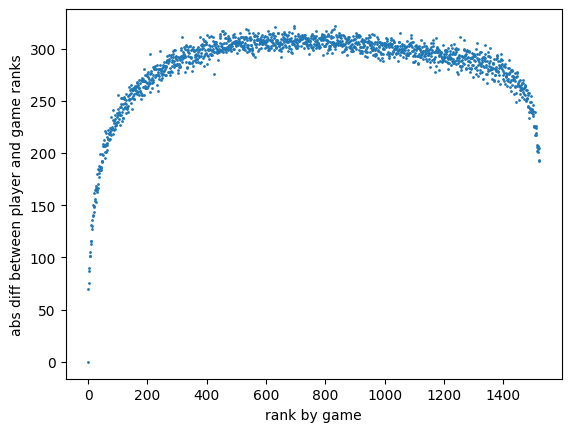

In [ ]:
plt.scatter(np.arange(N), rank_difference, s=1)
plt.xlabel('rank by game')
plt.ylabel('abs diff between player and game ranks')
plt.show()

We can see that the differences in the forecast of close words are much smaller than in the forecast of distant ones. This seems logical: all models will say that the word "mother" is close to the word "father". However, the models may differ in what is closer to the word "mother": "guitar" or "basketball".

## Player rank using Algorithm

Let's implement the following algorithm.
The word for the first move is chosen randomly. The game returns how close this word is to the target word (rank $k$). The player looks at his matrix, which word is at the position $k$ from the hidden one and uses this word for the next move. Etc. If the player at some point previously called a word that is at the position $k$ from the hidden one, then he calls the word at the position $k-1$ ($k+1$, $k-2$, $k+2$ e.t.c.).
This happens until the player guesses the target word.

In [ ]:
# Auxiliary function. Determining the closest number to the number num that has not been used before

def get_nearest_num(num, used, num_set=np.arange(N)):
    if num not in used:
        return num
    min_diff = np.inf
    nearest = np.nan
    for i in num_set:
        if i not in used:
            diff = np.abs(num - i)
            if diff < min_diff:
                min_diff = diff
                nearest = i
    return nearest

In [ ]:
get_nearest_num(5, [3,4,5,6,111])

7

In [ ]:
def player_rank_using(target, first_move):
    attempts = 1
    move = first_move
    used = []
    while target != move:
        attempts += 1
        game_output = int(game_rank[target][move])
        used.append(move)
        next_move = -1
        curr_used = []
        while next_move == -1:
            output = get_nearest_num(game_output, curr_used)
            for k in range(N):
                if player_rank[move][k] == output:
                    next_move = k
            if next_move in used:
                curr_used.append(output)
                next_move = -1
        move = next_move
    return attempts

Let's run 1000 simulations of games where the player uses this algorithm.
Let's look at the various parameters.

In [ ]:
np.random.seed(42)
M = 100
PRU_num_moves_to_win = np.zeros(M)
for k in tqdm(range(M)):
    i = np.random.choice(N)
    j = np.random.choice(N)
    PRU_num_moves_to_win[k] = player_rank_using(i, j)

100%|██████████| 100/100 [02:52<00:00,  1.73s/it]


In [ ]:
PRU_num_moves_to_win.mean()

467.73

In [ ]:
PRU_num_moves_to_win.std()

421.9663696315146

In [ ]:
np.median(PRU_num_moves_to_win)

305.0

In [ ]:
(PRU_num_moves_to_win < 200).mean()

0.38

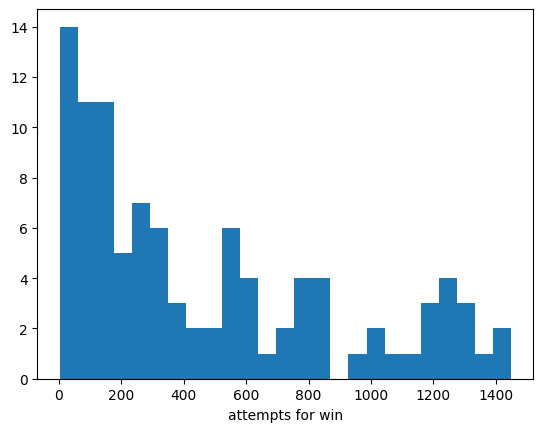

In [ ]:
plt.hist(PRU_num_moves_to_win, bins=25)
plt.xlabel('attempts for win')
plt.show()

The estimated expectation of the number of moves is $461$. This is significantly less than $761$ with a random choice of words.

The standard deviation for random word selection is approximately equal to $\sqrt{\frac{(N-1)^2}{12}} \approx 439$.

The estimated standard deviation when using the PRU algorithm is $365$. That's less than $439$.

Finally, let's look at the empirical distribution function of the number of attempts. We see that it is decreasing. In almost 30% of cases, 200 attempts are enough to guess the word.

## Further ideas

You can try another model as a player's faith and study how the proximity of the player and game matrices affects the average number of moves to guess the target word.

You can improve the algorithm by teaching it to take into account all the information, not just the previous move.

In [ ]:
def maximum_likelihood_using(target, first_move):
    attempts = 1
    move = first_move
    used = np.array([False for _ in range(N)])
    sum_diff = np.zeros(N)
    while target != move:
        attempts += 1
        game_output = int(game_rank[target][move])
        used[move] = True
        for k in range(N):
            sum_diff[k] += np.abs(player_rank[k][move] - game_output)
        available_sumdiff = np.where(used, np.inf, sum_diff)
        move = np.argmin(available_sumdiff)
    return attempts

In [ ]:
maximum_likelihood_using(0, 1)

6

In [ ]:
np.random.seed(42)
M = 1000
MLU_num_moves_to_win = np.zeros(M)
for k in tqdm(range(M)):
    i = np.random.choice(N)
    j = np.random.choice(N)
    MLU_num_moves_to_win[k] = maximum_likelihood_using(i, j)

100%|██████████| 1000/1000 [04:08<00:00,  4.03it/s]


In [ ]:
MLU_num_moves_to_win.mean()

57.484

In [ ]:
MLU_num_moves_to_win.std()

86.79688787047608

In [ ]:
np.median(MLU_num_moves_to_win)

27.0

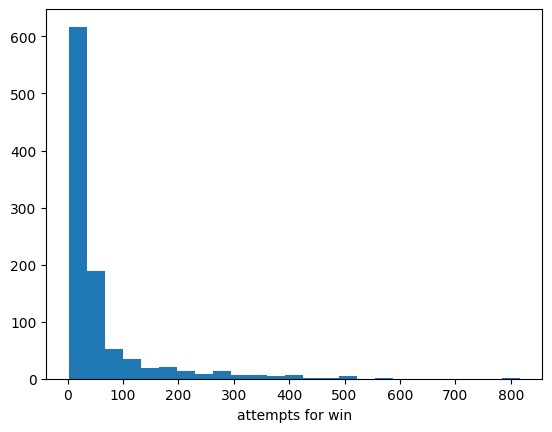

In [ ]:
plt.hist(MLU_num_moves_to_win, bins=25)
plt.xlabel('attempts for win')
plt.show()

Further experiments

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 51.0 MB/s eta 0:00:00


In [ ]:
import numpy as np

import torch
import torch.nn.functional as f

from transformers import BertModel, BertTokenizer

from time import sleep

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
from abc import ABC
class Analyzer(ABC):
  def __init__(
      self,
      similarity_func,
      bert_version : str,
      device,
      ):
      self.similarity_func = similarity_func

      self.bert_version = bert_version
      self.tokenizer = BertTokenizer.from_pretrained(bert_version)
      self.model = BertModel.from_pretrained(bert_version)

      self.device=device

      self.model = self.model.eval()

  def get_word_emb(
      self,
      token : str
      ):
      encoding = self.tokenizer(
          token,
          padding=True,
          return_tensors='pt'
          ).to(self.device)

      for tokens in encoding['input_ids']:
        self.tokenizer.convert_ids_to_tokens(tokens)

      with torch.no_grad():
        embed = self.model(**encoding)[0]

      avg_embed = embed.mean(dim=1)

      return avg_embed

  def get_similarity(self, embed1, embed2):
      return self.similarity_func(embed1, embed2)[0]

In [ ]:
embed_calc = Analyzer(
  similarity_func=torch.nn.CosineSimilarity(),
  bert_version='bert-base-cased',
  device=device
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
N = len(nouns)
emb_dict = dict()
for noun in tqdm(nouns):
  emb_dict[noun] = embed_calc.get_word_emb(token=noun)

sim = np.zeros((N, N))
for i in tqdm(range(N)):
    for j in range(N):
        sim[i][j] = embed_calc.get_similarity(embed1=emb_dict[nouns[i]], embed2=emb_dict[nouns[j]])

sim

100%|██████████| 1522/1522 [01:44<00:00, 14.60it/s]


array([[1.00000012, 0.81332028, 0.8856914 , ..., 0.7811842 , 0.853266  ,
        0.80579859],
       [0.81332028, 1.00000012, 0.83177865, ..., 0.80395412, 0.80477798,
        0.86534268],
       [0.8856914 , 0.83177865, 0.99999994, ..., 0.80946112, 0.8548736 ,
        0.84284598],
       ...,
       [0.7811842 , 0.80395412, 0.80946112, ..., 0.99999994, 0.83667254,
        0.80629098],
       [0.853266  , 0.80477798, 0.8548736 , ..., 0.83667254, 1.        ,
        0.83477962],
       [0.80579859, 0.86534268, 0.84284598, ..., 0.80629098, 0.83477962,
        0.99999982]])

In [ ]:
game_rank = np.zeros((N, N))
for i in tqdm(range(N)):
    game_rank[i] = np.argsort(np.argsort(sim[i])[::-1])

100%|██████████| 1522/1522 [00:00<00:00, 4927.47it/s]


In [ ]:
embed_calc_2 = Analyzer(
  similarity_func=torch.nn.CosineSimilarity(),
  bert_version='bert-base-multilingual-cased',
  device=device
)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
emb_dict_2 = dict()
for noun in tqdm(nouns):
  emb_dict_2[noun] = embed_calc_2.get_word_emb(token=noun)

N = len(nouns)
sim_player = np.zeros((N, N))
for i in tqdm(range(N)):
    for j in range(N):
        sim_player[i][j] = embed_calc_2.get_similarity(embed1=emb_dict_2[nouns[i]], embed2=emb_dict_2[nouns[j]])

sim_player

100%|██████████| 1522/1522 [01:44<00:00, 14.56it/s]


array([[1.        , 0.51946557, 0.64499462, ..., 0.51973492, 0.63035846,
        0.56273776],
       [0.51946557, 1.00000012, 0.53727967, ..., 0.5609529 , 0.55786639,
        0.70961928],
       [0.64499462, 0.53727967, 1.        , ..., 0.6877808 , 0.65552384,
        0.60472906],
       ...,
       [0.51973492, 0.5609529 , 0.6877808 , ..., 1.00000012, 0.59895444,
        0.59058654],
       [0.63035846, 0.55786639, 0.65552384, ..., 0.59895444, 1.        ,
        0.5952974 ],
       [0.56273776, 0.70961928, 0.60472906, ..., 0.59058654, 0.5952974 ,
        1.        ]])

In [ ]:
player_rank = np.zeros((N, N))
for i in tqdm(range(N)):
    player_rank[i] = np.argsort(np.argsort(sim_player[i])[::-1])

100%|██████████| 1522/1522 [00:00<00:00, 4282.22it/s]


In [ ]:
np.abs(game_rank - player_rank).mean()

447.10922846866197

In [ ]:
rank_difference = np.zeros(N)
for i in tqdm(range(N)):
    for j in range(N):
        r = game_rank[i][j]
        rank_difference[int(r)] += np.abs(game_rank[i][j] - player_rank[i][j])
rank_difference /= N

100%|██████████| 1522/1522 [00:18<00:00, 82.67it/s]


In [ ]:
rank_difference.mean()

447.109228468662

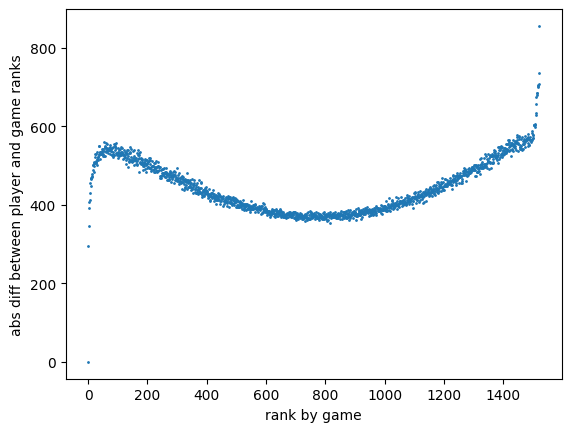

In [ ]:
plt.scatter(np.arange(N), rank_difference, s=1)
plt.xlabel('rank by game')
plt.ylabel('abs diff between player and game ranks')
plt.show()

In [ ]:
np.random.seed(42)
M = 100
PRU_num_moves_to_win = np.zeros(M)
for k in tqdm(range(M)):
    i = np.random.choice(N)
    j = np.random.choice(N)
    PRU_num_moves_to_win[k] = player_rank_using(i, j)

100%|██████████| 100/100 [05:46<00:00,  3.47s/it]


In [ ]:
PRU_num_moves_to_win.mean()

621.25

In [ ]:
PRU_num_moves_to_win.std()

399.60493928378816

In [ ]:
np.median(PRU_num_moves_to_win)

575.5

In [ ]:
(PRU_num_moves_to_win < 200).mean()

0.16

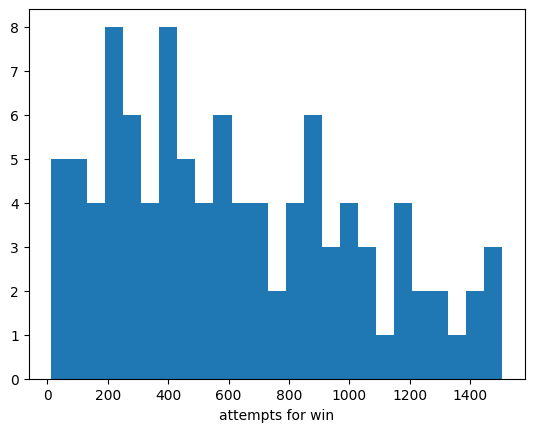

In [ ]:
plt.hist(PRU_num_moves_to_win, bins=25)
plt.xlabel('attempts for win')
plt.show()

In [ ]:
np.random.seed(42)
M = 100
MLU_num_moves_to_win = np.zeros(M)
for k in tqdm(range(M)):
    i = np.random.choice(N)
    j = np.random.choice(N)
    MLU_num_moves_to_win[k] = maximum_likelihood_using(i, j)

100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


In [ ]:
MLU_num_moves_to_win.mean()

197.45

In [ ]:
MLU_num_moves_to_win.std()

179.12025988145507

In [ ]:
np.median(MLU_num_moves_to_win)

153.0

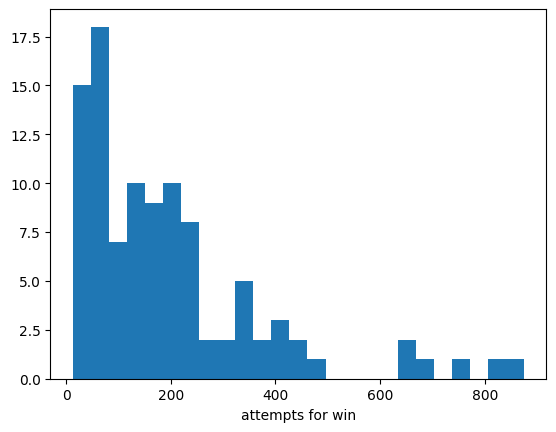

In [ ]:
plt.hist(MLU_num_moves_to_win, bins=25)
plt.xlabel('attempts for win')
plt.show()

In [ ]:
def get_nearest_num(num, used, num_set=np.arange(N)):
    if num not in used:
        return num
    min_diff = np.inf
    nearest = np.nan
    for i in num_set:
        if i not in used:
            diff = np.abs(num - i)
            if diff < min_diff:
                min_diff = diff
                nearest = i
    return nearest

def player_rank_using(target, first_move, game_rank, player_rank):
    attempts = 1
    move = first_move
    used = []
    while target != move:
        attempts += 1
        game_output = int(game_rank[target][move])
        used.append(move)
        next_move = -1
        curr_used = []
        while next_move == -1:
            output = get_nearest_num(game_output, curr_used)
            for k in range(N):
                if player_rank[move][k] == output:
                    next_move = k
            if next_move in used:
                curr_used.append(output)
                next_move = -1
        move = next_move
    return attempts

def maximum_likelihood_using(target, first_move, game_rank, player_rank):
    attempts = 1
    move = first_move
    used = np.array([False for _ in range(N)])
    sum_diff = np.zeros(N)
    while target != move:
        attempts += 1
        game_output = int(game_rank[target][move])
        used[move] = True
        for k in range(N):
            sum_diff[k] += np.abs(player_rank[k][move] - game_output)
        available_sumdiff = np.where(used, np.inf, sum_diff)
        move = np.argmin(available_sumdiff)
    return attempts

In [ ]:
def experiment(sim, sim_player):
  game_rank = np.zeros((N, N))
  for i in tqdm(range(N)):
      game_rank[i] = np.argsort(np.argsort(sim[i])[::-1])

  player_rank = np.zeros((N, N))
  for i in tqdm(range(N)):
      player_rank[i] = np.argsort(np.argsort(sim_player[i])[::-1])

  rank_difference = np.zeros(N)
  for i in tqdm(range(N)):
      for j in range(N):
          r = game_rank[i][j]
          rank_difference[int(r)] += np.abs(game_rank[i][j] - player_rank[i][j])
  rank_difference /= N
  print(f"Average rank diffirence: {rank_difference.mean()}")

  plt.scatter(np.arange(N), rank_difference, s=1)
  plt.xlabel('rank by game')
  plt.ylabel('abs diff between player and game ranks')
  plt.show()

  print("-"*25)
  print("PRU")
  np.random.seed(42)
  M = 200
  PRU_num_moves_to_win = np.zeros(M)
  for k in tqdm(range(M)):
      i = np.random.choice(N)
      j = np.random.choice(N)
      PRU_num_moves_to_win[k] = player_rank_using(i, j, game_rank, player_rank)

  print(f"Average moves to win in PRU = {PRU_num_moves_to_win.mean()}")
  print(f"Standard deviation of moves to win in PRU = {PRU_num_moves_to_win.std()}")
  print(f"Median of moves to win in PRU = {np.median(PRU_num_moves_to_win)}")

  plt.hist(PRU_num_moves_to_win, bins=25)
  plt.xlabel('attempts for win')
  plt.show()

  print("-"*25)
  print("MLU")
  np.random.seed(42)
  M = 200
  MLU_num_moves_to_win = np.zeros(M)
  for k in tqdm(range(M)):
      i = np.random.choice(N)
      j = np.random.choice(N)
      MLU_num_moves_to_win[k] = maximum_likelihood_using(i, j, game_rank, player_rank)

  print(f"Average moves to win in MLU = {MLU_num_moves_to_win.mean()}")
  print(f"Standard deviation of moves to win in MLU = {MLU_num_moves_to_win.std()}")
  print(f"Median of moves to win in MLU = {np.median(MLU_num_moves_to_win)}")

  plt.hist(MLU_num_moves_to_win, bins=25)
  plt.xlabel('attempts for win')
  plt.show()

100%|██████████| 1522/1522 [00:10<00:00, 142.30it/s]


Average rank diffirence: 447.109228468662


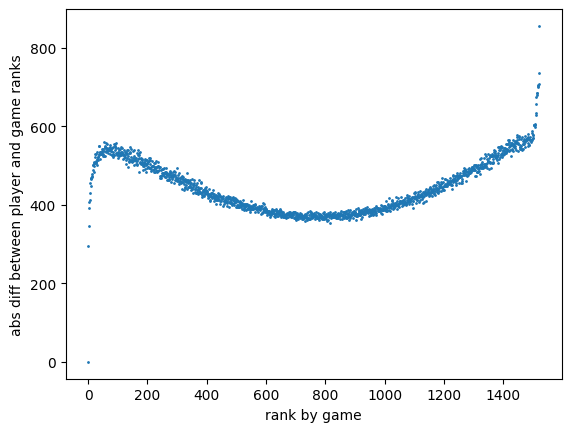

-------------------------
PRU


100%|██████████| 25/25 [00:38<00:00,  1.52s/it]


Average moves to win in PRU = 558.6
Standard deviation of moves to win in PRU = 318.11846849876537
Median of moves to win in PRU = 584.0


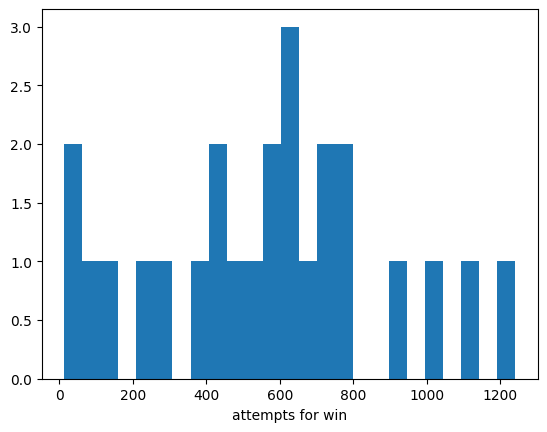

-------------------------
MLU


100%|██████████| 25/25 [00:21<00:00,  1.18it/s]


Average moves to win in MLU = 191.96
Standard deviation of moves to win in MLU = 160.97788171050084
Median of moves to win in MLU = 146.0


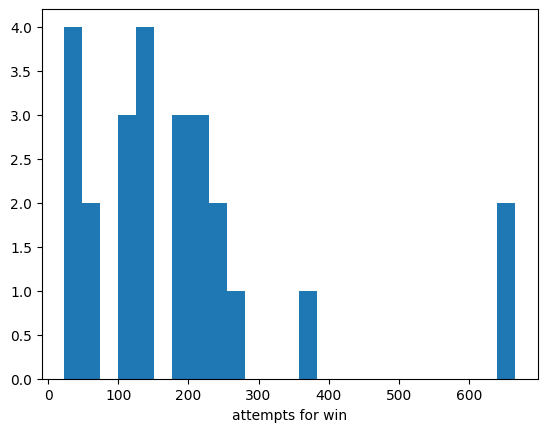

In [ ]:
experiment(sim=sim, sim_player=sim_player)

In [ ]:
def create_sim_setting(bert_version):
  embed_calc = Analyzer(
    similarity_func=torch.nn.CosineSimilarity(),
    bert_version=bert_version,
    device=device
  )

  N = len(nouns)
  emb_dict = dict()
  for noun in tqdm(nouns):
    emb_dict[noun] = embed_calc.get_word_emb(token=noun)

  sim = np.zeros((N, N))
  for i in tqdm(range(N)):
      for j in range(N):
          sim[i][j] = embed_calc.get_similarity(embed1=emb_dict[nouns[i]], embed2=emb_dict[nouns[j]])

  return sim

In [ ]:
sim_pref_2 = create_sim_setting(bert_version='digitalepidemiologylab/covid-twitter-bert')

Some weights of the model checkpoint at digitalepidemiologylab/covid-twitter-bert were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1522/1522 [02:20<00:00, 10.80it/s]


In [ ]:
sim_pref_1 = create_sim_setting(bert_version='JungleLee/bert-toxic-comment-classification')

Some weights of the model checkpoint at JungleLee/bert-toxic-comment-classification were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1522/1522 [02:41<00:00,  9.42it/s]


In [ ]:
list_of_prefs = [
    (sim, 'bert-base-cased'),
    (sim_player, 'bert-base-multilingual-cased'),
    (sim_pref_1, 'JungleLee/bert-toxic-comment-classification'),
    (sim_pref_2, 'digitalepidemiologylab/covid-twitter-bert')
    ]

game pref is bert-base-cased
player pref is bert-base-multilingual-cased


100%|██████████| 1522/1522 [00:10<00:00, 151.97it/s]


Average rank diffirence: 447.109228468662


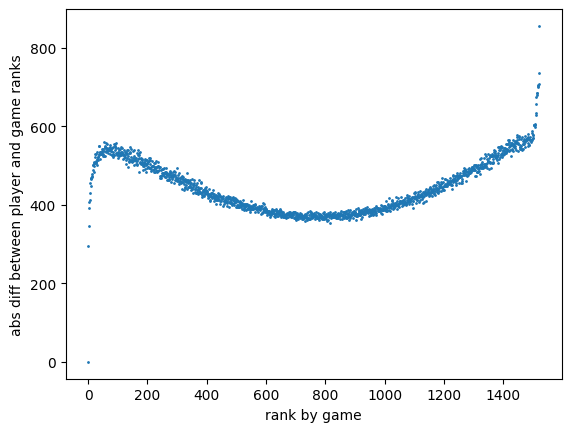

-------------------------
PRU


100%|██████████| 200/200 [09:37<00:00,  2.89s/it]


Average moves to win in PRU = 647.19
Standard deviation of moves to win in PRU = 410.4710146892226
Median of moves to win in PRU = 570.5


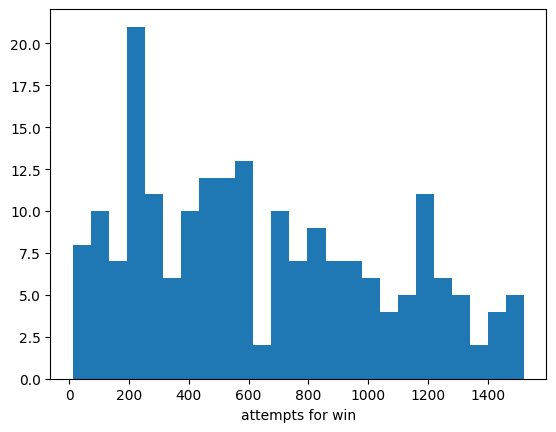

-------------------------
MLU


100%|██████████| 200/200 [03:13<00:00,  1.03it/s]


Average moves to win in MLU = 215.7
Standard deviation of moves to win in MLU = 196.67963799031153
Median of moves to win in MLU = 162.5


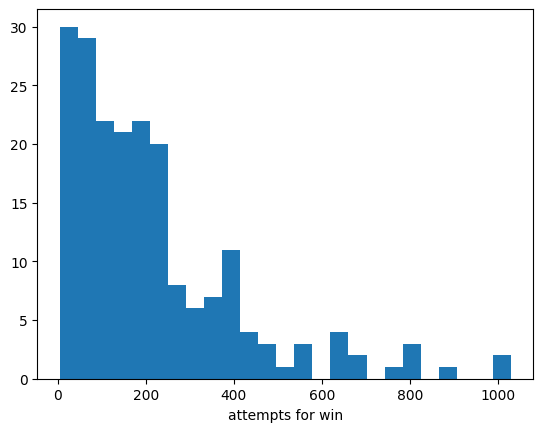

--------------------------------------------------
game pref is bert-base-cased
player pref is JungleLee/bert-toxic-comment-classification


100%|██████████| 1522/1522 [00:06<00:00, 223.06it/s]


Average rank diffirence: 459.23468584285496


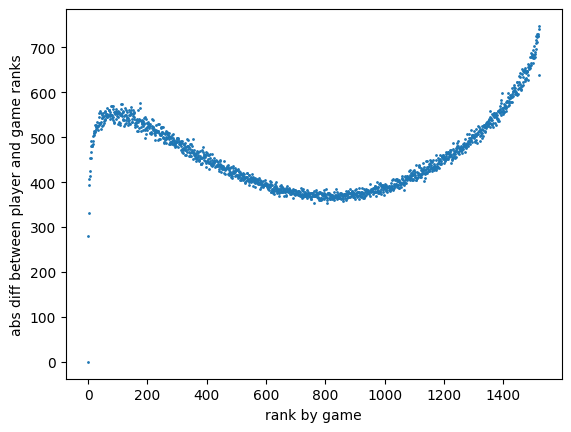

-------------------------
PRU


100%|██████████| 200/200 [09:01<00:00,  2.71s/it]


Average moves to win in PRU = 605.69
Standard deviation of moves to win in PRU = 416.8861162236037
Median of moves to win in PRU = 543.0


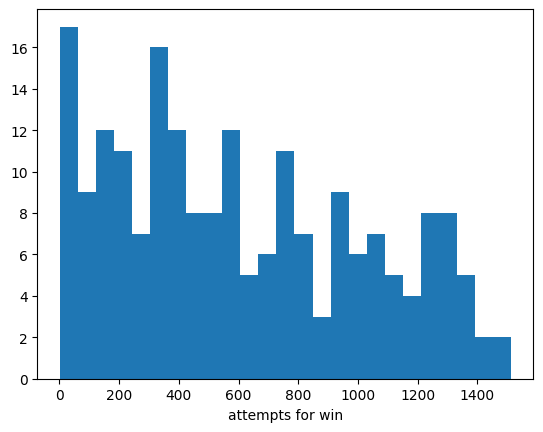

-------------------------
MLU


100%|██████████| 200/200 [03:56<00:00,  1.18s/it]


Average moves to win in MLU = 266.075
Standard deviation of moves to win in MLU = 166.26361410422908
Median of moves to win in MLU = 262.0


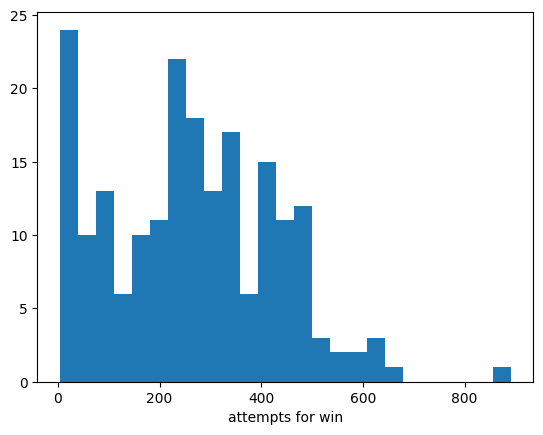

--------------------------------------------------
game pref is bert-base-cased
player pref is digitalepidemiologylab/covid-twitter-bert


100%|██████████| 1522/1522 [00:09<00:00, 167.90it/s]


Average rank diffirence: 476.1521987632982


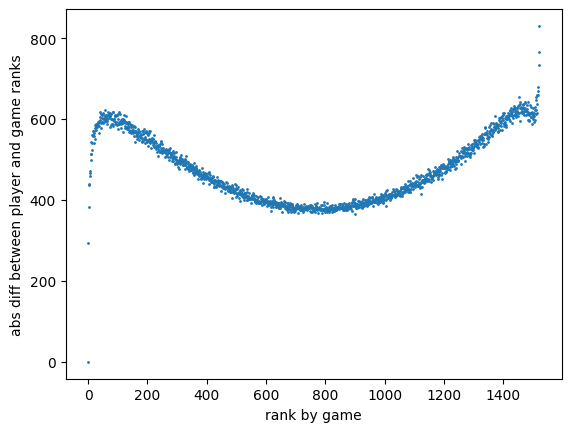

-------------------------
PRU


100%|██████████| 200/200 [07:42<00:00,  2.31s/it]


Average moves to win in PRU = 639.86
Standard deviation of moves to win in PRU = 411.881002718018
Median of moves to win in PRU = 619.0


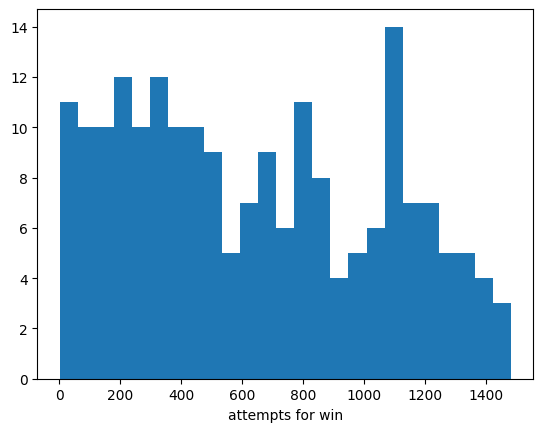

-------------------------
MLU


100%|██████████| 200/200 [03:25<00:00,  1.03s/it]


Average moves to win in MLU = 230.39
Standard deviation of moves to win in MLU = 196.8204204344661
Median of moves to win in MLU = 179.0


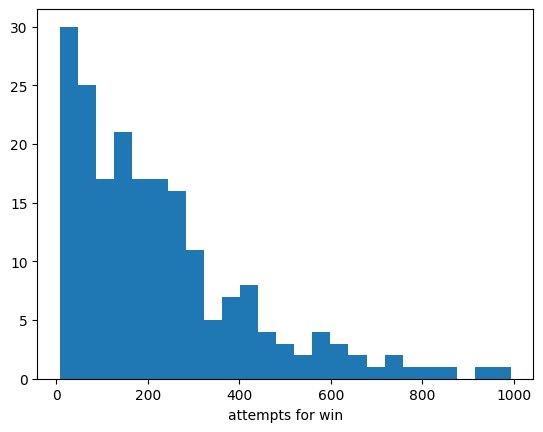

--------------------------------------------------
game pref is bert-base-multilingual-cased
player pref is JungleLee/bert-toxic-comment-classification


100%|██████████| 1522/1522 [00:06<00:00, 218.64it/s]


Average rank diffirence: 476.3552452768938


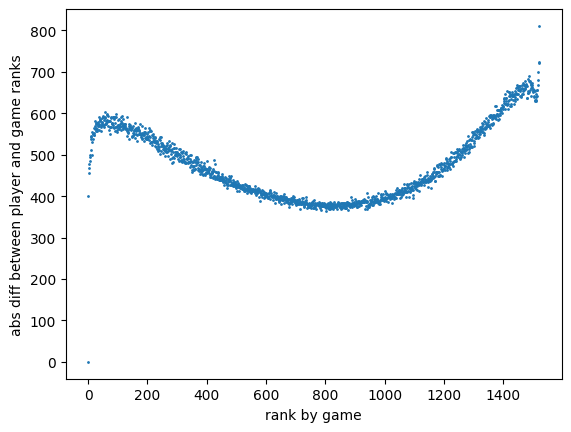

-------------------------
PRU


100%|██████████| 200/200 [08:36<00:00,  2.58s/it]


Average moves to win in PRU = 648.825
Standard deviation of moves to win in PRU = 396.26542162419366
Median of moves to win in PRU = 604.5


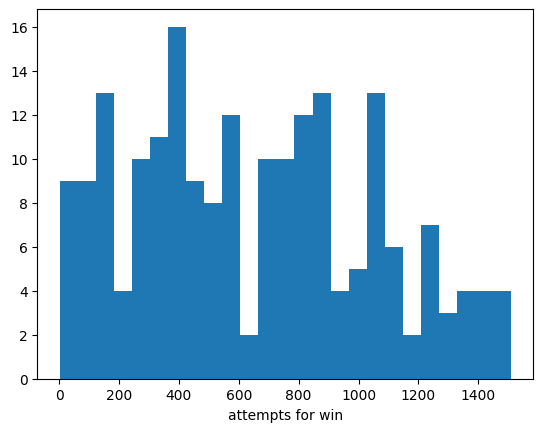

-------------------------
MLU


100%|██████████| 200/200 [05:11<00:00,  1.56s/it]


Average moves to win in MLU = 353.86
Standard deviation of moves to win in MLU = 212.47258740835252
Median of moves to win in MLU = 333.0


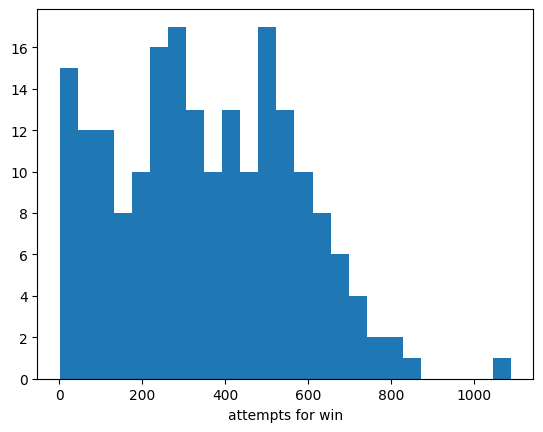

--------------------------------------------------
game pref is bert-base-multilingual-cased
player pref is digitalepidemiologylab/covid-twitter-bert


100%|██████████| 1522/1522 [00:08<00:00, 185.01it/s]


Average rank diffirence: 492.4524771161813


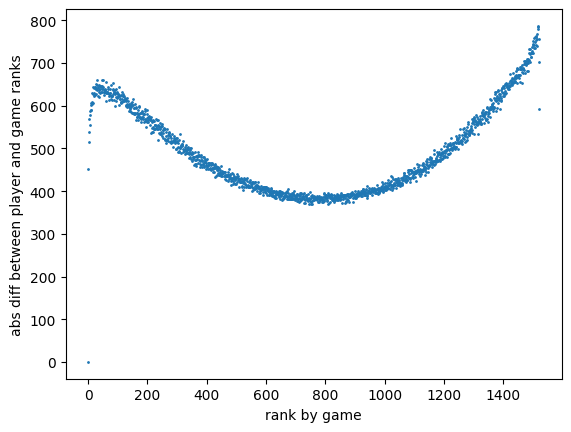

-------------------------
PRU


100%|██████████| 200/200 [14:35<00:00,  4.38s/it]


Average moves to win in PRU = 769.85
Standard deviation of moves to win in PRU = 449.36661814157935
Median of moves to win in PRU = 793.0


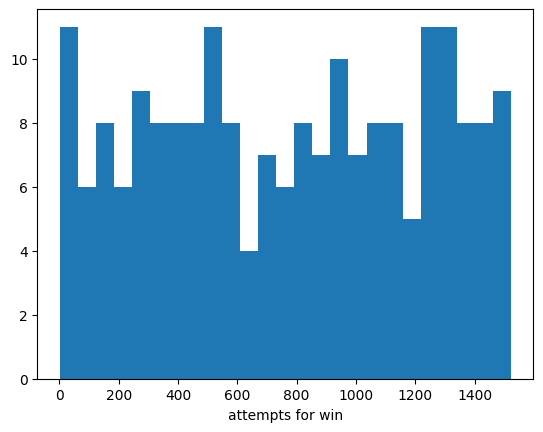

-------------------------
MLU


100%|██████████| 200/200 [04:29<00:00,  1.35s/it]


Average moves to win in MLU = 306.225
Standard deviation of moves to win in MLU = 232.12025843299418
Median of moves to win in MLU = 260.5


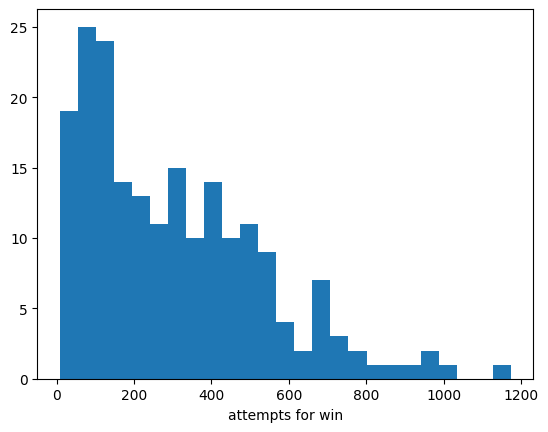

--------------------------------------------------
game pref is JungleLee/bert-toxic-comment-classification
player pref is digitalepidemiologylab/covid-twitter-bert


100%|██████████| 1522/1522 [00:08<00:00, 171.47it/s]


Average rank diffirence: 450.6197029636294


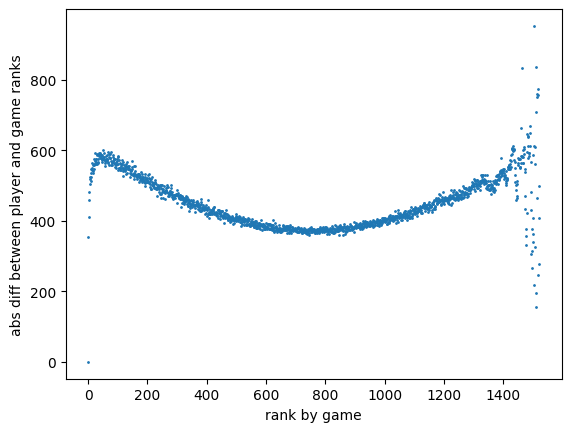

-------------------------
PRU


100%|██████████| 200/200 [09:25<00:00,  2.83s/it]


Average moves to win in PRU = 702.08
Standard deviation of moves to win in PRU = 412.4683910313613
Median of moves to win in PRU = 685.5


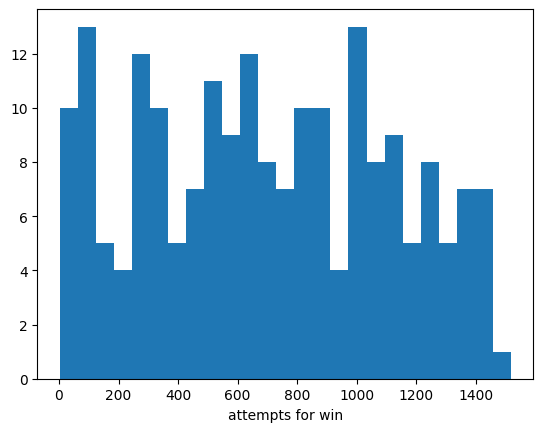

-------------------------
MLU


100%|██████████| 200/200 [04:47<00:00,  1.44s/it]


Average moves to win in MLU = 326.285
Standard deviation of moves to win in MLU = 264.0154612423295
Median of moves to win in MLU = 268.0


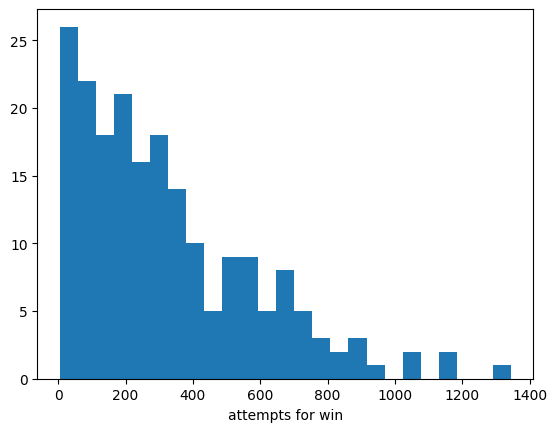

--------------------------------------------------


In [ ]:
for id, (pref, model_name) in enumerate(list_of_prefs):
  for player_pref, player_model_name in list_of_prefs[id+1:]:
    print(f'game pref is {model_name}')
    print(f'player pref is {player_model_name}')
    experiment(sim=pref, sim_player=player_pref)
    print('-'*50)